In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import itertools
import pathlib
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = '/content/drive/MyDrive/TA DATAMINING/Data Set Tomat/Data Set Tomat'

In [ ]:
filepaths = []
labels = []

In [ ]:
def is_image_valid(filepath):
    try:
        img = Image.open(filepath)  # Mencoba membuka gambar
        img.verify()  # Memeriksa integritas gambar
        return True
    except (IOError, SyntaxError) as e:
        print(f"Invalid image found and skipped: {filepath}")
        return False

In [ ]:

# Membaca gambar dari subfolder (Matang, Mentah, Setengah Matang)
folds = os.listdir(data_path)
for fold in folds:
    f_path = os.path.join(data_path, fold)
    filelists = os.listdir(f_path)
    for file in filelists:
        filepaths.append(os.path.join(f_path, file))

# Membaca file .jpg dari seluruh subdirektori
for root, dirs, files in os.walk(data_path):
    for file in files:
        filepath = os.path.join(root, file)
        if filepath.endswith('.jpg') and is_image_valid(filepath): # Memeriksa format gambar dan apakah gambar valid
            # Menyimpan path file dan label (nama folder induk)
            filepaths.append(filepath)
            labels.append(os.path.basename(root))  # Nama subfolder sebagai label

In [ ]:
# Membuat DataFrame untuk file path dan label
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='label')
train_df = pd.concat([Fseries, Lseries], axis=1)

In [ ]:
# Mengecek total nilai NaN di seluruh DataFrame
train_df.isna().sum().sum()

899

In [ ]:
# Cek dan hapus baris dengan NaN jika ada
train_df.dropna(inplace=True)

In [ ]:
# Memeriksa jumlah gambar setelah pembersihan
print(f"Total images after cleaning: {len(train_df)}")
print(train_df.head())  # Menampilkan beberapa baris dari DataFrame

Total images after cleaning: 899
                                           filepaths            label
0  /content/drive/MyDrive/TA DATAMINING/Data Set ...  Setengah Matang
1  /content/drive/MyDrive/TA DATAMINING/Data Set ...  Setengah Matang
2  /content/drive/MyDrive/TA DATAMINING/Data Set ...  Setengah Matang
3  /content/drive/MyDrive/TA DATAMINING/Data Set ...  Setengah Matang
4  /content/drive/MyDrive/TA DATAMINING/Data Set ...  Setengah Matang


In [ ]:
print(train_df['label'].value_counts())

label
Busuk              374
Tua                324
Setengah Matang    100
Mentah              51
Matang              50
Name: count, dtype: int64


In [ ]:
# Split data ke training, validation, dan testing
train_df, test_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

In [ ]:
# Pengaturan untuk ImageDataGenerator dan ukuran gambar
img_size = (224, 224)  # ukuran lebih kecil untuk mempercepat
batch_size = 16

In [ ]:
# Augmentasi data untuk pelatihan dan uji
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='label', target_size=img_size,
    class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size
)

Found 575 validated image filenames belonging to 5 classes.
Found 144 validated image filenames belonging to 5 classes.
Found 180 validated image filenames belonging to 5 classes.


In [ ]:
# Mendapatkan kelas dan contoh gambar
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(train_gen)

# # Mendapatkan jumlah kelas
# classes = list(train_gen.class_indices.keys())
num_class = len(classes) # num_class is correctly calculated here based on train_gen

# Membangun model CNN sederhana
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_class, activation='softmax') # Use num_class here to match the number of classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,605 (42.61 MB)

 Trainable params: 11,169,605 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Pelatihan model
Epochs = 10
history = model.fit(train_gen, epochs=Epochs, validation_data=valid_gen, shuffle=True)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.4870 - loss: 92.8686 - val_accuracy: 0.8889 - val_loss: 0.3813
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8575 - loss: 0.4389 - val_accuracy: 0.9514 - val_loss: 0.1788
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.8782 - loss: 0.4190 - val_accuracy: 0.4514 - val_loss: 6.5354
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8014 - loss: 1.5755 - val_accuracy: 0.8889 - val_loss: 0.3175
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.8220 - loss: 0.5553 - val_accuracy: 0.8681 - val_loss: 0.3436
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8944 - loss: 0.2836 - val_accuracy: 0.8958 - val_loss: 0.2790
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9023 - loss: 0.2587 - val_accuracy: 0.9097 - val_loss: 0.2371
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9197 - loss: 0.2492 - val_accuracy: 0.8472 - val_los

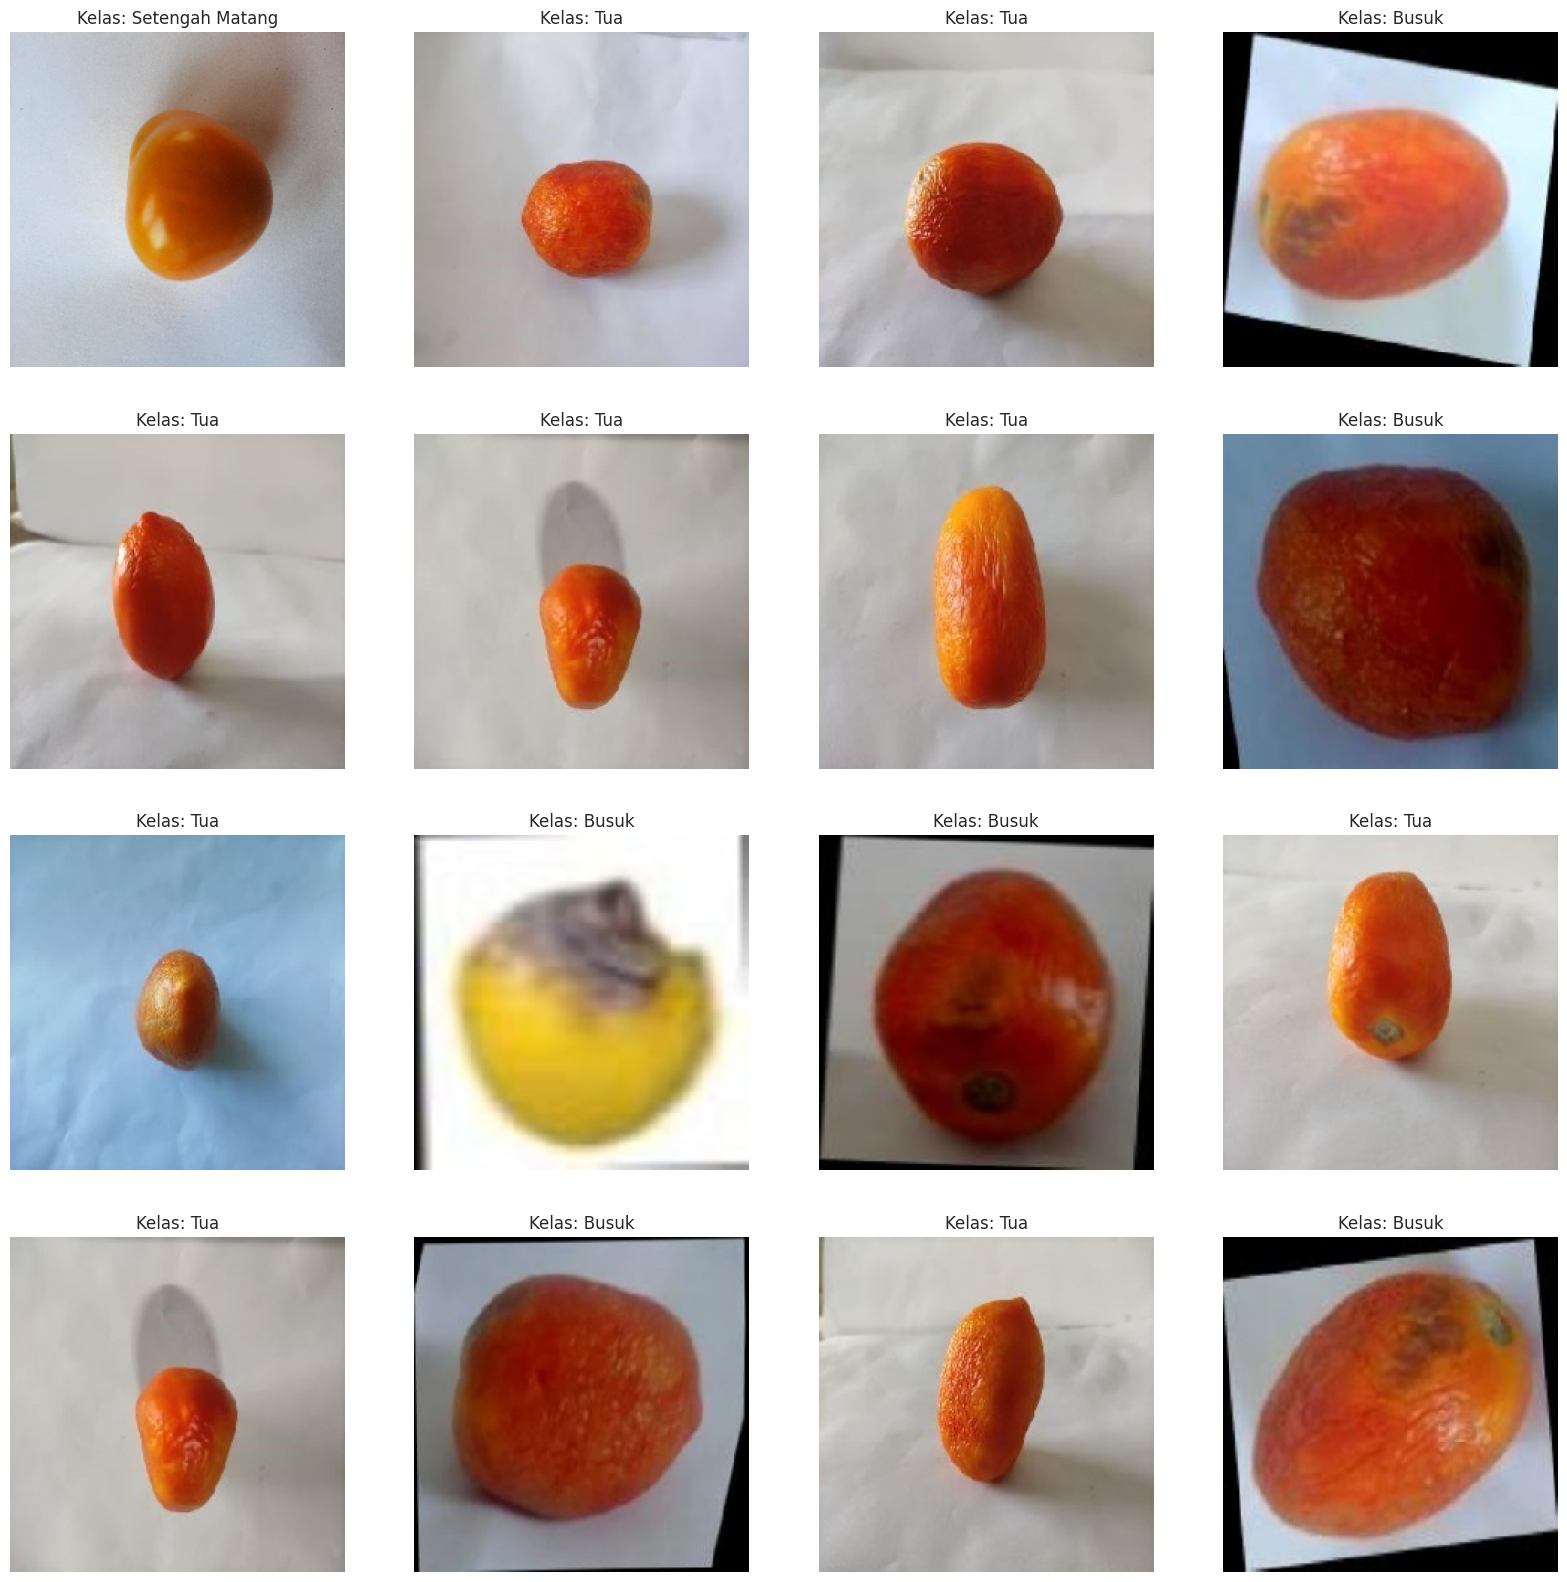

In [ ]:
# Menampilkan contoh gambar
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(f"Kelas: {class_name}")
    plt.axis('off')

plt.show()

In [ ]:
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops

In [ ]:

def extract_features(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = rgb2gray(img)

    # Ekstraksi fitur warna (contoh: mean dan std dari setiap channel)
    mean_r = np.mean(img[:,:,0])
    std_r = np.std(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    std_g = np.std(img[:,:,1])
    mean_b = np.mean(img[:,:,2])
    std_b = np.std(img[:,:,2])

    # Ekstraksi fitur tekstur menggunakan GLCM (Gray-Level Co-occurrence Matrix)
    glcm = graycomatrix(gray.astype(int), distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]

    return [mean_r, std_r, mean_g, std_g, mean_b, std_b, contrast, dissimilarity, homogeneity, energy, correlation, ASM]

# Tambahkan fitur ke DataFrame
features = []
for filepath in train_df['filepaths']:
    features.append(extract_features(filepath))

feature_names = ['mean_r', 'std_r', 'mean_g', 'std_g', 'mean_b', 'std_b', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
feature_df = pd.DataFrame(features, columns = feature_names)
train_df = pd.concat([train_df, feature_df], axis=1)

# ... (Lanjutkan sisa kode Anda)

                                             filepaths            label  \
36   /content/drive/MyDrive/TA DATAMINING/Data Set ...  Setengah Matang   
615  /content/drive/MyDrive/TA DATAMINING/Data Set ...              Tua   
459  /content/drive/MyDrive/TA DATAMINING/Data Set ...            Busuk   
447  /content/drive/MyDrive/TA DATAMINING/Data Set ...            Busuk   
828  /content/drive/MyDrive/TA DATAMINING/Data Set ...              Tua   

         mean_r      std_r      mean_g      std_g      mean_b      std_b  \
36   160.987442  17.348959  168.936356  40.973358  177.888031  58.541661   
615         NaN        NaN         NaN        NaN         NaN        NaN   
459  188.624969  21.860356  175.723267  42.336246  170.416946  55.129845   
447   81.493393  59.055529   69.854477  65.536082   73.438232  74.688513   
828         NaN        NaN         NaN        NaN         NaN        NaN   

     contrast  dissimilarity  homogeneity  energy  correlation  ASM  
36        0.0         

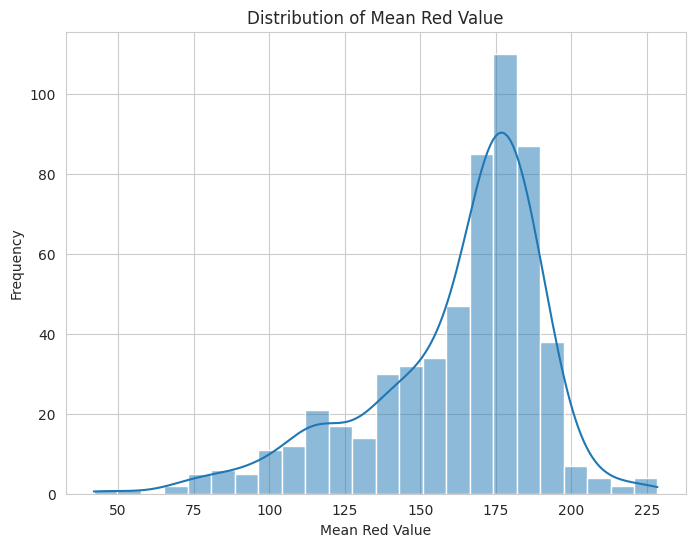

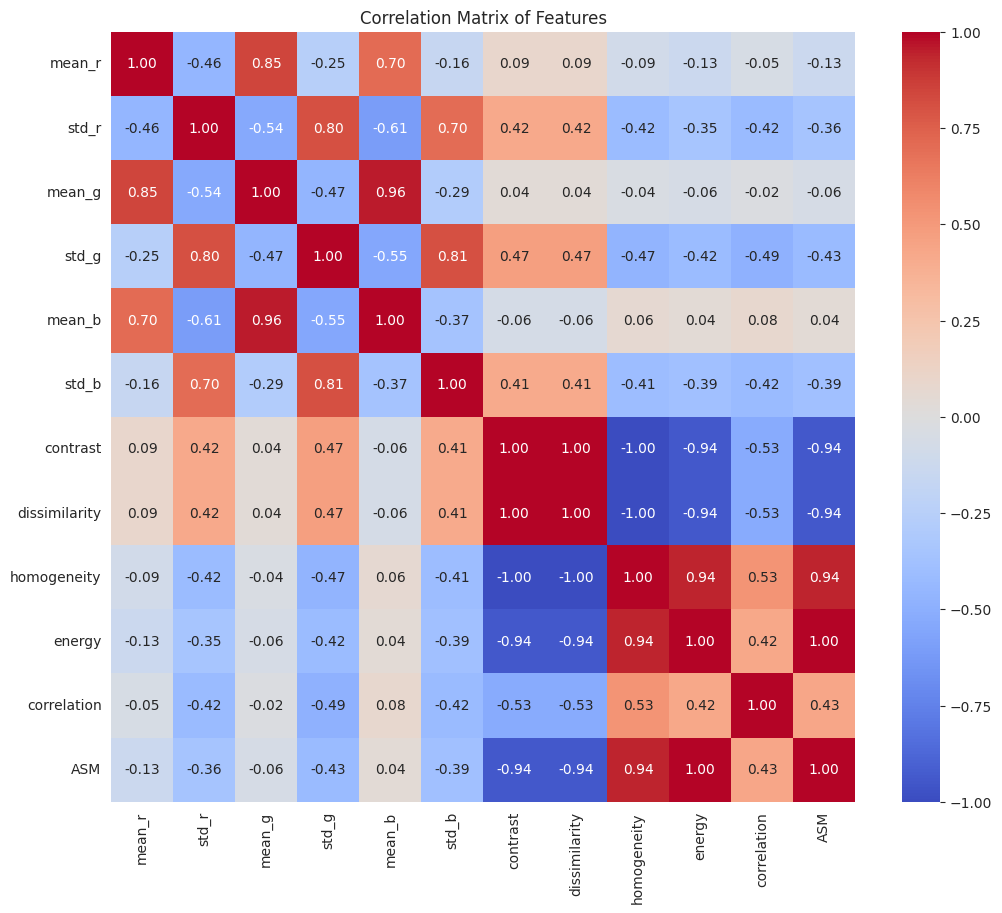

In [ ]:

print(train_df.head())

# Display summary statistics for the features.
print(train_df.describe())

# Visualize the distribution of a specific feature (e.g., 'mean_r')
plt.figure(figsize=(8, 6))
sns.histplot(train_df['mean_r'], kde=True)
plt.title('Distribution of Mean Red Value')
plt.xlabel('Mean Red Value')
plt.ylabel('Frequency')
plt.show()

# Example: Correlation matrix to see relationships between features.
correlation_matrix = train_df[feature_names].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# ... (rest of your code)

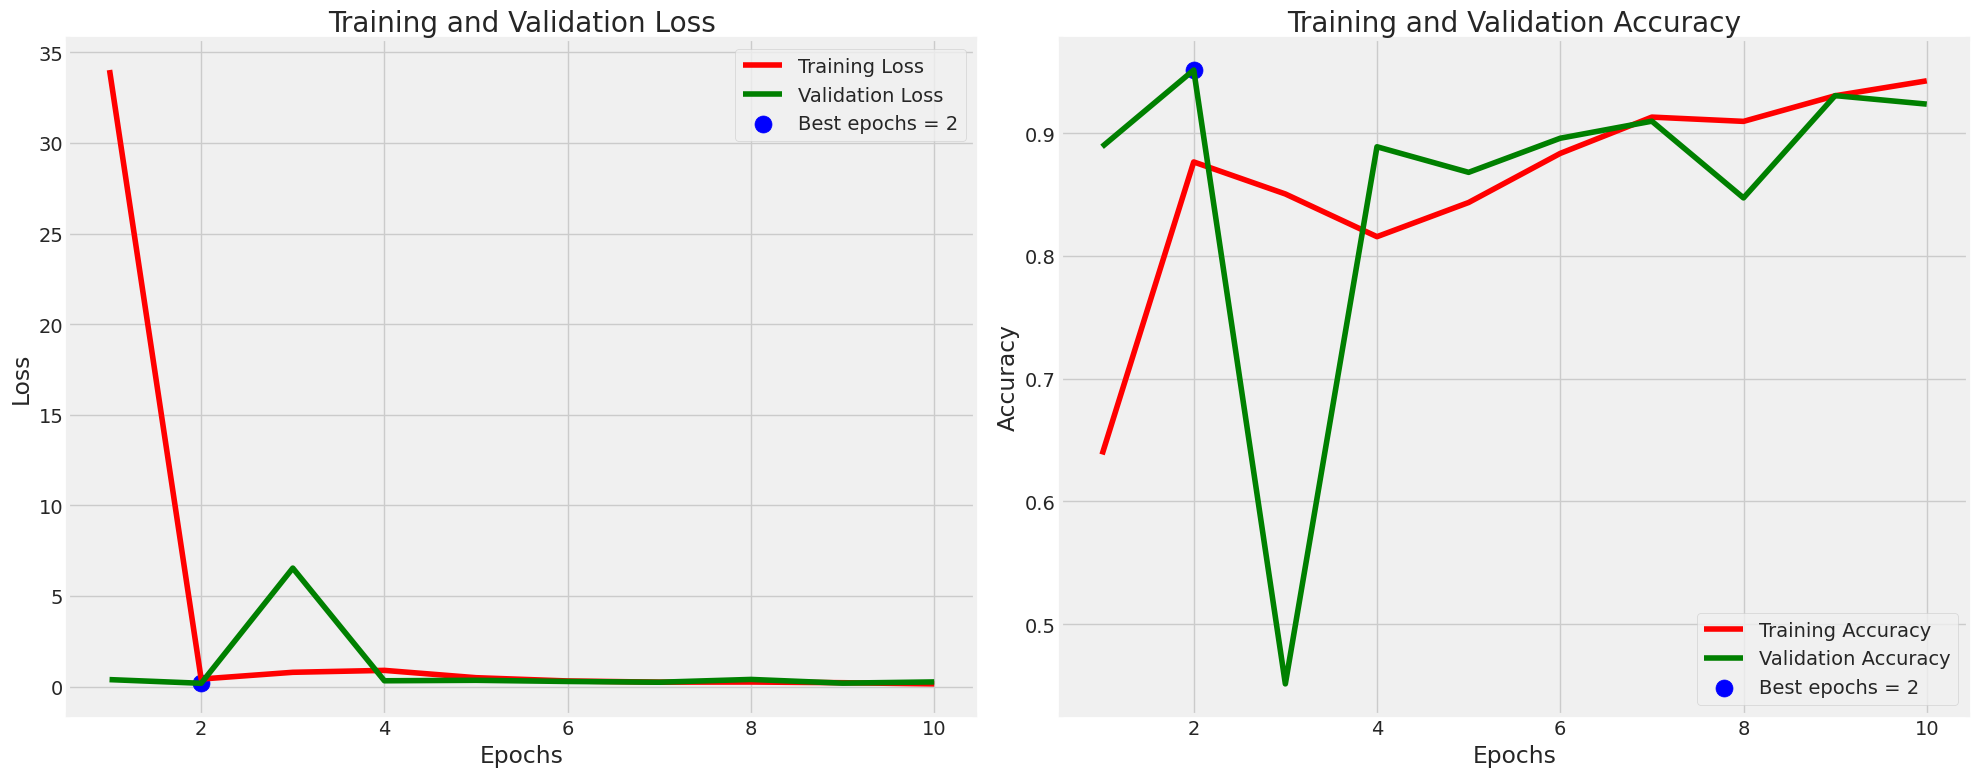

In [ ]:
# Menampilkan hasil pelatihan
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
Epochs = [i + 1 for i in range(len(train_acc))]
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]


loss_label = f'Best epochs = {str(index_loss + 1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

#Plot Loss
plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, 'r', label='Training Loss')
plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, val_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9298 - loss: 0.3493
Test Loss: 0.2978590726852417
Test Accuracy: 0.9277777671813965


In [ ]:
# Confusion Matrix
y_pred = np.argmax(model.predict(test_gen), axis=-1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step


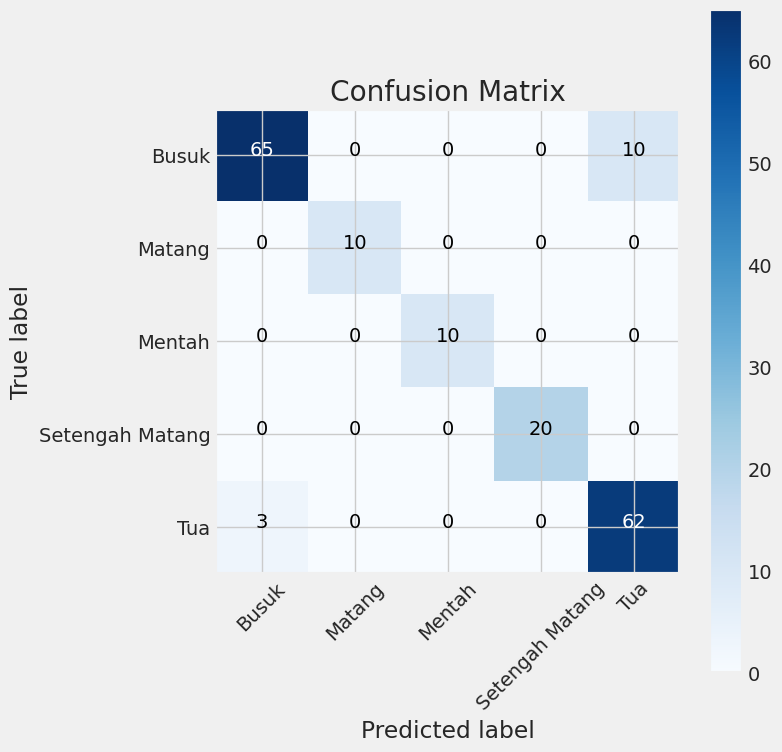

                 precision    recall  f1-score   support

          Busuk       0.96      0.87      0.91        75
         Matang       1.00      1.00      1.00        10
         Mentah       1.00      1.00      1.00        10
Setengah Matang       1.00      1.00      1.00        20
            Tua       0.86      0.95      0.91        65

       accuracy                           0.93       180
      macro avg       0.96      0.96      0.96       180
   weighted avg       0.93      0.93      0.93       180



In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Menambahkan angka di dalam Confusion Matrix
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_labels))

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(image_path, model, img_size):
    img = image.load_img(image_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    return predicted_class, prediction


# Example usage (assuming you have 'model' loaded and img_size defined):
image_path = input("Masukkan path gambar: ") # Example: '/content/drive/MyDrive/TA DATAMINING/Data Set Tomat/Data Set Tomat/Matang/IMG_20230713_093129.jpg'
predicted_class, prediction = predict_image(image_path, model, img_size)

class_labels = list(test_gen.class_indices.keys())  # Assuming test_gen is defined as before

print(f"Predicted class index: {predicted_class}")
print(f"Predicted class label: {class_labels[predicted_class]}")
print(f"Prediction probabilities: {prediction}")

KeyboardInterrupt: Interrupted by user